In [1]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving an homogeneous elastic perforated plate. It is subjected to uniform normal traction under a plane-stress condition. By symmetry, only one quarter of the plate is modelled.

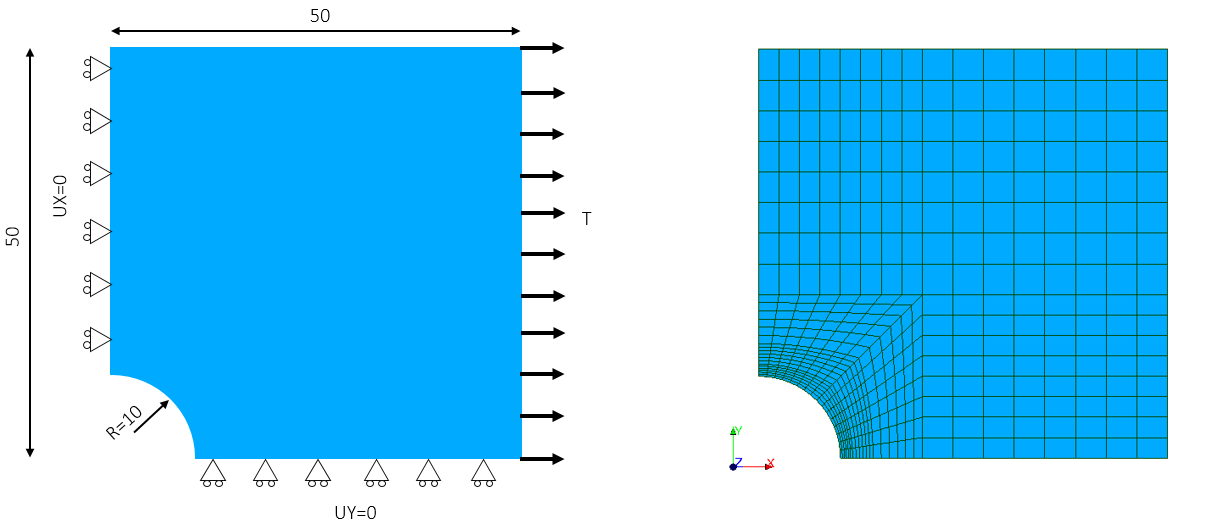

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [3]:
from mesh_utils import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './PerforatedPlate.med')

Loaded SALOME .med mesh: 531 nodes, 630 elements
Node groups (4): ['left', 'right', 'top', 'bottom']
Element groups (6): ['all', 'right_s', 'bottom_e', 'top_e', 'right_e', 'left_e']


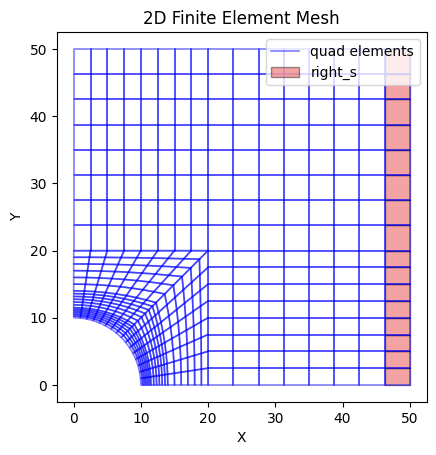

In [4]:
mesh.plot(show_nodes=False, element_groups_to_plot=['right_s'])

### Dirichlet boundary conditions

In [5]:
from feinn_solver import BoundaryCondition

bcs = {
        'left': BoundaryCondition(dof=1, value=0.0),
        'bottom': BoundaryCondition(dof=2, value=0.0),                
        }

### Define material

In [6]:
from matmodels import LinearElasticPlaneStress

steel = LinearElasticPlaneStress(emod = 20*1e-2, nu = 0.25)

matfield = {'all': steel}

### von Neumman boundary conditions

In [7]:
from feinn_solver import LineLoad

traction = {
            'right_e': LineLoad(fx = 1.0*1e-2, fy = 0, reference = "global"),
            }


### Model

In [8]:
from feinn_solver import NFEA

thickness = {
            'all': 1.0
                }

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      thickness = thickness,
                      line_loads = traction,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 630 elements have assigned material
[thickness] Applied 1 thickness groups
[line_load] Applied 1 line load groups
[BC] Processed 2 Dirichlet condition(s) → 54 total constraint(s)
[BC] Applied Dirichlet BCs → 54 fixed DOFs


In [9]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 3.39e-14  Energetic error: -1.14e-14
Iter   2 | du error: 1.67e-14  Res error: 1.12e-14  Energetic error: -2.44e-30
Converged in 2 iterations


In [10]:
fem_solver.udisp

tensor([ 1.6802,  0.0000,  1.8147,  ..., -0.6384,  0.1596, -0.6501])

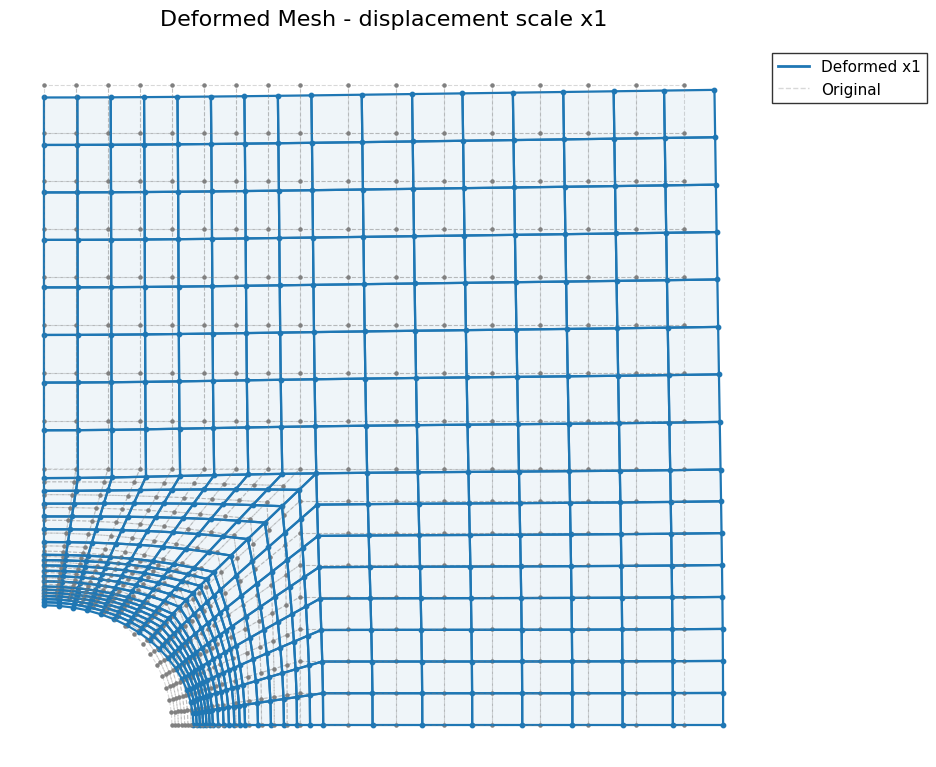

In [11]:
fem_solver.plot_deformed_mesh(scale=1)

In [12]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    thickness = thickness,
    line_loads = traction,
    verbose=False,
    nnet = mFCNet(num_layers=3, num_neurons=16),
    bc_weight=1,
    nnet_init = 'xavier',
    )

In [13]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 0
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [14]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   lbfgs_epochs = 50,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
Warmup loss: 1.28e-02
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 5.10e-01

Epoch 1/50 (L-BFGS)
Total Loss: 2.693e-02
  Domain: 2.534e-02
  BC:     1.586e-03

Epoch 10/50 (L-BFGS)
Total Loss: 2.620e-03
  Domain: 2.483e-03
  BC:     1.373e-04

Epoch 20/50 (L-BFGS)
Total Loss: 9.084e-04
  Domain: 8.742e-04
  BC:     3.414e-05

Epoch 30/50 (L-BFGS)
Total Loss: 3.362e-04
  Domain: 3.285e-04
  BC:     7.731e-06

Epoch 40/50 (L-BFGS)
Total Loss: 1.525e-04
  Domain: 1.507e-04
  BC:     1.848e-06

Epoch 50/50 (L-BFGS)
Total Loss: 8.061e-05
  Domain: 7.863e-05
  BC:     1.975e-06
 Maximum gradient (Inf-Norm): 2.53e-04


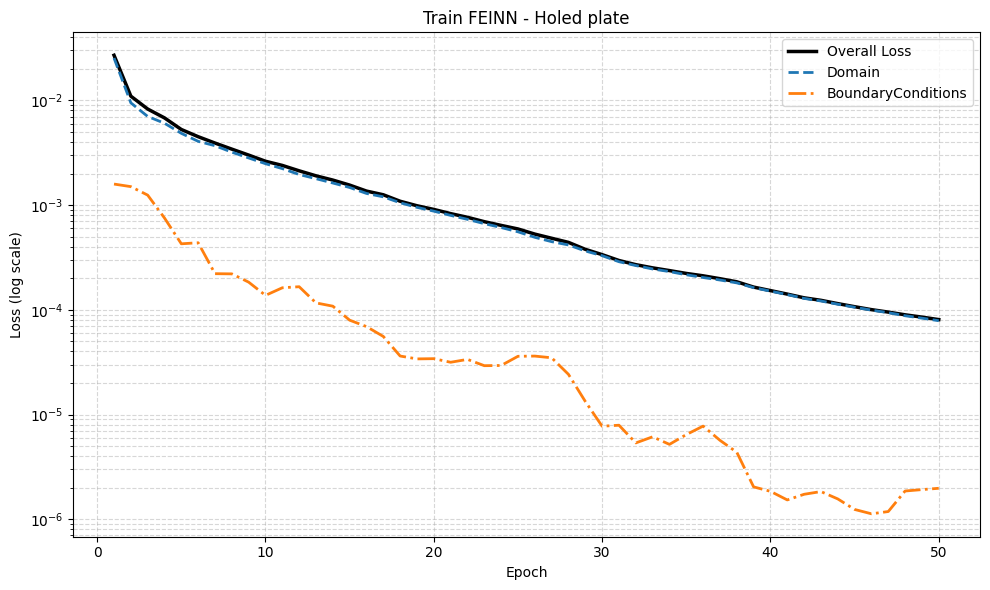

In [15]:
feinn_solver.plot_history(title="Train FEINN - Holed plate")

C:\GitHub\CEIA\feinn_project\src\evaluator.py:36: RuntimeWarning: divide by zero encountered in divide
  100 * np.abs((self.y_pred - self.y_true) / self.y_true),


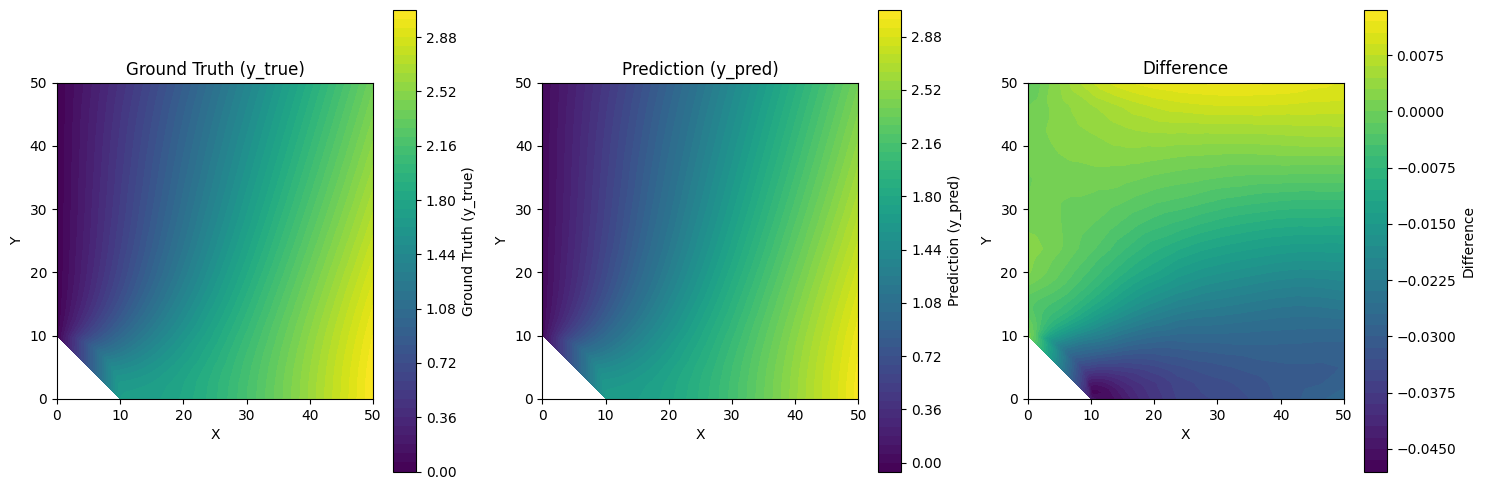

In [16]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

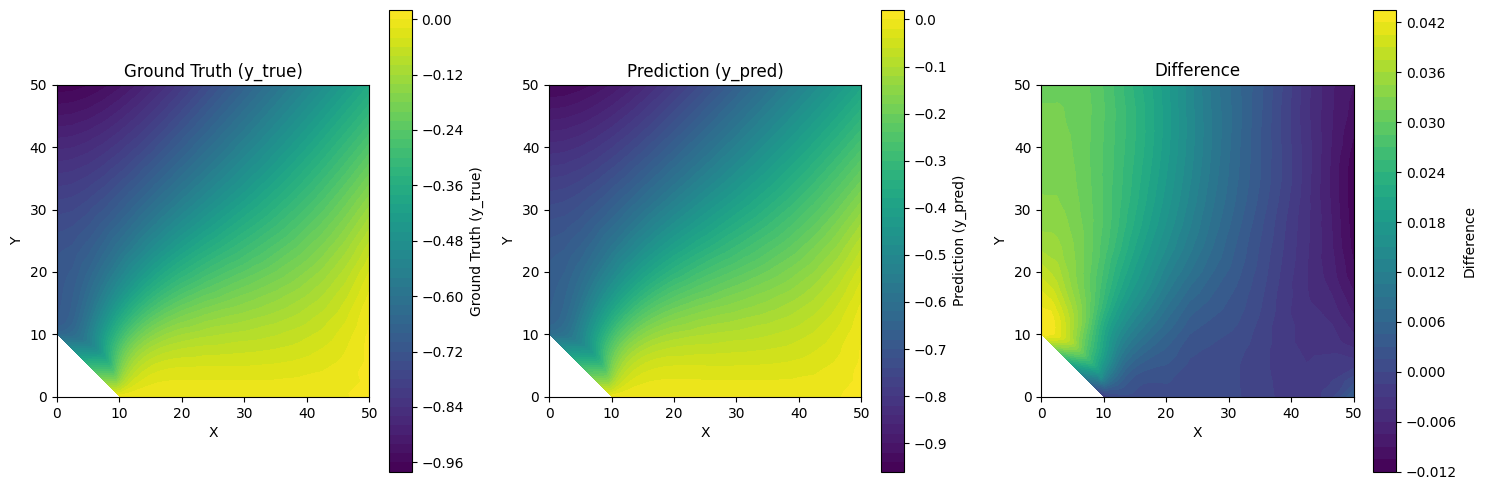

In [17]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')